![alt text](awesome_logo.png "Awesome Retirement Portfolio Projector Tool")

---

In [8]:
# imports
# For data management
import sqlalchemy as sql
import pandas as pd
import os
import datetime
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
from sqlalchemy import inspect

# For Portfolo Optimization and visualizations
import numpy as np
import pandas as pd
import hvplot.pandas  
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
from bokeh.models.formatters import NumeralTickFormatter

# For Simulation
from MCForecastTools import MCSimulation

# Project functions
from awesome_metrics import get_portfolio_allocation_and_valuation, get_annual_expected_return_volatility_and_sharpe_ratio

# My Current Portfolio

In [15]:
# Get porfolio and report data from user
connection_string = 'sqlite:///awesome_app.db'
engine = sql.create_engine(connection_string, echo = False)
inspect(engine).get_table_names()

try:
    portfolio_df = pd.read_sql_query("SELECT * FROM portfolio", engine)
    # handle exception
except Exception as ex:
    print(f"""
    There is not portfolio already available. Please run `python awesome_tool.py` from the command line to enter your portfolio. 
    Detailed instructions on usage are available in the Usage section of the README file, including the use of .env file to access ALPACA.
    Thanks for running the program.
    """)



    There is not portfolio already available. Please run `python awesome_tool.py` from the command line to enter your portfolio. 
    Detailed instructions on usage are available in the Usage section of the README file.
    Thanks for running the program.
    


In [3]:
# Create empty portfolio of diversification options
diversification_options = {
    "SPY": "Equity",
    "AGG": "Fixed Income",
}

portfolio_additions = []
for symbol, asset_type in diversification_options.items():
    # skip if symbol included in portfolio already
    if symbol not in portfolio_df.index:
        portfolio_additions.append({
            "symbol": symbol,
            "quantity": 0,
            "type": asset_type
        })
    
etf_addition_for_diversification = pd.DataFrame(portfolio_additions)

In [4]:
# Portfolio extended for recommendation based on risk profile
portfolio_extended_df = pd.concat([portfolio_df, etf_addition_for_diversification], axis=0).sort_values("symbol",ignore_index=True)

# Setting format for asset type in columns for future optimization
portfolio_extended_df["equity"] = portfolio_extended_df["type"] == "Equity"
portfolio_extended_df["fixed income"] = portfolio_extended_df["type"] == "Fixed Income"

In [5]:
# Get Alpaca data
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

# Set the tickers
tickers = portfolio_extended_df["symbol"]

# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"
# Set the number of years of data to fetch
num_years = 30

# Fetch batches of data from alpaca api to get as much historical data as possible (up to num_years)
batch_size = 1000
num_days_data_needed = num_years * 365


first_date = datetime.datetime.now()
last_date = first_date - datetime.timedelta(days=num_days_data_needed)

def format_date_iso(date):
    return pd.Timestamp(date, tz="America/New_York").isoformat()

# empty DF to hold alpaca data
portfolio_close_prices_df = pd.DataFrame()


next_batch_date = first_date
while num_days_data_needed > 0:
    end_date = str(next_batch_date).split()[0]
    
    next_batch_date -= datetime.timedelta(days=batch_size)
    if next_batch_date < last_date:
        next_batch_date = last_date

    start_date = str(next_batch_date).split()[0]
    
    results_batch_df = alpaca.get_barset(
        tickers,
        timeframe,
        start = format_date_iso(start_date),
        end = format_date_iso(end_date),
        limit = batch_size
    ).df
    
    results_batch_df.drop(['open', 'high', 'low', 'volume'], level=1, axis=1, inplace=True)

    # add batch to portfolio_close_prices_df
    portfolio_close_prices_df = pd.concat([portfolio_close_prices_df, results_batch_df])
    num_days_data_needed -= batch_size

portfolio_close_prices_df.sort_index(inplace=True)

Python-dotenv could not parse statement starting at line 1


In [6]:
# Original portfolio addition of allocation
[portfolio_df, original_valuation] = get_portfolio_allocation_and_valuation(
    portfolio_df,
    portfolio_close_prices_df[portfolio_df["symbol"]]
)

display(portfolio_df)
latest_pricing_date = str(portfolio_close_prices_df.index[-1]).split()[0]

print()
print(f"\033[1m My total portfolio value as of {latest_pricing_date} is ${original_valuation:,.2f}")

,symbol,quantity,type,price,total,Allocation
0,GOOG,10.0,Equity,2768.58,27685.8,0.126500
1,CMG,20.0,Equity,1891.95,37839.0,0.172892
2,IBM,500.0,Equity,139.11,69555.0,0.317806
3,XLB,1000.0,Equity,83.78,83780.0,0.382802



 My total portfolio value as of 2021-08-20 is $218,859.80


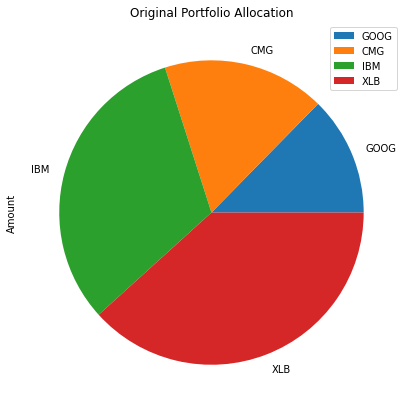

In [7]:
print()
portfolio_df.set_index("symbol").plot.pie(
    figsize = [7, 7],
    y = "Allocation",
    ylabel = "Amount",
    title = "Original Portfolio Allocation"
);

In [66]:
# INDIVIDUAL SECURITY ANALYSIS
#daily_returns_securities_df=portfolio_close_prices_df.pct_change()

#RETURN DISPERSION BOXPLOT
#daily_returns_securities_df.plot(
#    kind='box', 
#    figsize=(25,10), 
#    title= 'Daily Returns Extended Portfolio (Original and Diversifying ETFs'
#);

# SUMMARY STATISTICS
#display(daily_returns_securities_df.describe())

# CORRELATION MATRIX
# Calculates correlation of securities in the client_portfolio_close_prices_df
#print(f"\033[1m Table of Correlations between Assets")
#round(daily_returns_securities_df.corr(),2)

# Optimized Portfolio Recommendations

In [8]:
report_df = pd.read_sql_query("SELECT * FROM report", engine)
[risk_tolerance, years_until_retirement] = report_df.iloc[0]

print(f"\033[1m My risk level is {risk_tolerance}.")
print(f"\033[1m I plan on retiring in {years_until_retirement} years.")

 My risk level is high.
 I plan on retiring in 20.0 years.


In [9]:
# Optimization works with a minimization function, so instead of maximizing Sharpe Ratio, we will minimize the negative sharpe.
def negative_sharpe_ratio(portfolio_weights, portfolio_daily_returns):
    return get_annual_expected_return_volatility_and_sharpe_ratio(
        portfolio_weights,
        portfolio_daily_returns
    )[2] * -1

In [10]:
# Contraints: weight sum must be equal to 1 
def check_sum_of_portfolio_weights_is_one(portfolio_weights):
    '''
    Returns 0 if sum of portfolio_weights is 1.0
    '''
    return np.sum(portfolio_weights) - 1

In [11]:
# Constraint: equity allocation is less than maximum limit (inequality constraint, upper limit - equity allocation >0)
def check_sum_of_portfolio_equity_weights_is_less_than_upper_bound(portfolio_weights, asset_class_securities, equity_upper_limit):
    """
    Makes sure allocation in equity is less than the maximum allowed
    """
    portfolio_equity_allocation = sum(portfolio_weights * asset_class_securities['Equity'])
    return equity_upper_limit - portfolio_equity_allocation

In [12]:
# Constraint: equity allocation is more than minimum limit (inequality constraint, equity allocation - lower_limit >0)
def check_sum_of_portfolio_equity_weights_is_more_than_lower_bound(portfolio_weights, asset_class_securities, equity_lower_limit):
    """
    Makes sure allocation in equity is more than the minimum allowed
    """
    portfolio_equity_allocation = sum(portfolio_weights * asset_class_securities['Equity'])
    return portfolio_equity_allocation - equity_lower_limit

In [13]:
# Determination of the limits for total equity allocation given level of risk
# Here we defined the required arguments for optimization constraints
if risk_tolerance == 'high':
    [equity_lower_limit, equity_upper_limit] = [0.75, 0.90]

elif risk_tolerance == 'moderate':
    [equity_lower_limit, equity_upper_limit] = [0.4, 0.6]

elif risk_tolerance == 'low':
    [equity_lower_limit, equity_upper_limit] = [0.05, 0.2]

else: [equity_lower_limit, equity_upper_limit] = [0, 1]

In [14]:
# get df of security asset classes
asset_class_securities = portfolio_extended_df[['symbol', 'equity', 'fixed income']].set_index('symbol').sort_index()
asset_class_securities.columns = ['Equity', 'Fixed Income']

In [15]:
"""
DEFINITION OF CONSTRAINTS
By convention of minimize function it should be a function that returns zero for equality constraints, and a positive number for inequality constraints. 
Constraint type: 'eq' for equality, 'ineq' for inequality. 
'fun': The function defining the constraint:      
                              sum(portfolio_weights)=1  ==> sum(portfolio_weights) - 1 = 0
       portfolio_equity_allocation < equity_upper_limit ==> equity_upper_limit - portfolio_equity_allocation >0
       portfolio_equity allocation > equity_lower_limit ==> portfolio_equity_allocation - lower_limit >0
""" 
constraints = [
    {
        'type': 'eq',
        'fun': check_sum_of_portfolio_weights_is_one
    },{
        'type': 'ineq',
        'fun': check_sum_of_portfolio_equity_weights_is_less_than_upper_bound,
        'args': (asset_class_securities, equity_upper_limit)
    },{
        'type': 'ineq',
        'fun': check_sum_of_portfolio_equity_weights_is_more_than_lower_bound,
        'args': (asset_class_securities, equity_lower_limit)
    }
]

In [16]:
# Setting bounds for the weights of each security
# Only long positions are allowed
num_securities = len(portfolio_close_prices_df.columns)

lb=[0] * num_securities
ub=[1] * num_securities
        
bounds = Bounds(lb, ub)

In [17]:
# Initial Guess (equal distribution)
# n: number of stocks in the portfolio to optimize
initial_guess = [1 / num_securities] * num_securities

In [18]:
portfolio_daily_returns = portfolio_close_prices_df.pct_change(1).dropna()
portfolio_daily_returns.columns = portfolio_daily_returns.columns.droplevel(1)

In [19]:
# OPTIMIZATION 
# Sequential Least SQuares Programming (SLSQP) method is used, which is similar to Least Square optimization, but using less resources.
optimization_results = minimize(
    negative_sharpe_ratio,
    initial_guess,
    args = portfolio_daily_returns,
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)

In [17]:
# help(minimize)

In [20]:
# Optimization success
print(optimization_results.message)
print(f"Optimized Sharpe ratio: {-optimization_results.fun:.2f}" )

Optimization terminated successfully
Optimized Sharpe ratio: 0.81


In [21]:
# Optimal allocation (weights)
optimal_portfolio_weights = optimization_results.x

#Formatting results
portfolio_position_names  = pd.Series(portfolio_daily_returns.columns)
optimal_portfolio_weights = pd.Series(optimal_portfolio_weights)
optimal_portfolio_weights = pd.concat([portfolio_position_names, optimal_portfolio_weights], axis=1)
optimal_portfolio_weights.columns = ["symbol", "Optimal Allocation"]
optimal_portfolio_weights = optimal_portfolio_weights.set_index("symbol")

In [22]:
# Portfolio extended addition of allocation
portfolio_extended_df = get_portfolio_allocation_and_valuation(portfolio_extended_df, portfolio_close_prices_df)[0]
portfolio_extended_df = portfolio_extended_df.rename(columns={'Allocation': 'Original Allocation'}).set_index("symbol")

In [23]:
portfolio_allocation_comparison = pd.concat([
    portfolio_extended_df["type"],
    round(portfolio_extended_df["Original Allocation"] * 100, 2),
    round(optimal_portfolio_weights * 100, 2)
], axis=1)
portfolio_allocation_comparison.columns = ['Asset Type', 'Original Allocation %', 'Optimal Allocation %']

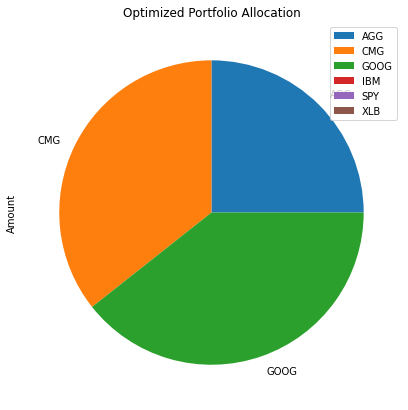

In [24]:
portfolio_allocation_comparison.plot.pie(
    figsize = [7, 7],
    y = "Optimal Allocation %",
    ylabel = "Amount",
    title = "Optimized Portfolio Allocation"
);

In [25]:
portfolio_allocation_comparison.hvplot.bar(
    title = "Allocation Comparison between Original and Optimized Portfolio (%)",
    ylabel = "Security Allocation (%)",
    xlabel = "Security Symbol",
    rot = 90,
    value_label = "Allocation (%)",
    height = 500,
    responsive = True
)

:Bars   [symbol,Variable]   (Allocation (%))

In [26]:
# Return of results 
# ORIGINAL PORTFOLIO Performance Metrics
[original_expected_return, original_volatility, original_Sharpe_ratio] = get_annual_expected_return_volatility_and_sharpe_ratio(
    np.array(portfolio_extended_df['Original Allocation']),
    portfolio_daily_returns
)

# print( f"Original Annual Expected Return:  {100*original_expected_return:.2f} %"  )
# print( f"Original Annual Volatility:       {100*original_volatility:.2f} % ") 
# print( f"Original Annual Sharpe ratio:     {original_Sharpe_ratio:.2f}")

In [27]:
# Optimal values (Max Sharpe ratio point)
[optimal_expected_return, optimal_volatility, maximum_Sharpe_ratio] = get_annual_expected_return_volatility_and_sharpe_ratio(
    optimization_results.x,
    portfolio_daily_returns
)

# print( f"Optimal Annual Expected Return:   {100*optimal_expected_return:.2f}%"  )
# print( f"Optimal Annual Volatility:        {100*optimal_volatility:.2f}%") 
# print( f"Maximum Annual Sharpe ratio:      {maximum_Sharpe_ratio:.2f}")

In [28]:
# Portfolios metrics original and optimized - data preparation
results_df=pd.DataFrame({"Original Portfolio":[original_expected_return*100, original_volatility*100, original_Sharpe_ratio],
                        "Optimal Portfolio":[optimal_expected_return*100, optimal_volatility*100, maximum_Sharpe_ratio]})
results_df=results_df.T
results_df.columns=["Expected Annual Return (%)", "Volatility (%)", "Sharpe Ratio"]
results_df
round(results_df,2)

,Expected Annual Return (%),Volatility (%),Sharpe Ratio
Original Portfolio,12.40,22.44,0.55
Optimal Portfolio,17.71,21.87,0.81


In [29]:
# Plot of results
results_df_for_plot=results_df[["Expected Annual Return (%)","Volatility (%)" ]]
results_df_for_plot["Sharpe Ratio"]=results_df["Sharpe Ratio"]*5000

results_df_for_plot=results_df_for_plot.reset_index()

# Setting axis limits 
max_vol=   max(results_df_for_plot["Volatility (%)"])
min_vol=   min(results_df_for_plot["Volatility (%)"])
max_return=max(results_df_for_plot["Expected Annual Return (%)"])


results_df_for_plot.hvplot(
    kind = "scatter",
    x = 'Volatility (%)',
    y = 'Expected Annual Return (%)',
    c = 'index',
    s = results_df_for_plot['Sharpe Ratio'],
    xlim = (min_vol-1, max_vol+1),
    ylim = (0, max_return+5),
    title = "Metrics Comparison: Original vs Optimized Portfolio",
    height = 350,
)

:Scatter   [Volatility (%)]   (Expected Annual Return (%),index,_size)

In [30]:
results_df["Sharpe Ratio"].hvplot.bar(title="Sharpe Ratio comparison between Original and Optimal Portfolios")

:Bars   [index]   (Sharpe Ratio)

# Portfolio Projections

Montecarlo Simultations projecting expected returns by retirement age

In [31]:
num_simulation = 100
num_trading_days = 252 * int(years_until_retirement)

In [32]:
MC_n_years_original = MCSimulation(
    portfolio_data = portfolio_close_prices_df,
    weights = list(portfolio_extended_df['Original Allocation']),
    num_simulation = num_simulation,
    num_trading_days = num_trading_days
)

In [33]:
MC_n_years_original.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.014850,0.999153,1.002920,1.018083,0.994602,0.998708,1.023674,0.987713,1.019392,1.012413,...,0.990295,0.997963,0.984641,1.002167,0.998387,0.998024,1.000660,0.985601,0.998808,1.009172
2,1.018303,0.993675,1.008719,1.042915,0.993282,0.976791,1.042256,0.996525,1.034342,1.008829,...,1.001529,0.986829,1.015044,1.007318,1.003182,0.981386,1.005282,0.992406,0.971517,1.014074
3,0.994549,0.991317,1.016497,1.064495,1.001620,0.987835,1.039876,0.981152,1.040213,0.997016,...,0.990397,1.009570,1.021533,1.006672,0.998034,0.997763,0.996030,1.004653,0.968817,1.010736
4,1.005752,0.992893,1.015083,1.077127,1.006721,0.980181,1.058302,0.987291,1.045252,1.000802,...,0.988093,1.006030,1.007919,1.009520,0.990513,1.008646,0.993736,0.988816,0.967803,1.004781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,12.449760,1.294308,5.157548,1.828874,6.288105,36.663797,3.288536,10.281993,9.185487,29.463653,...,3.633707,11.621957,3.008779,19.260073,5.533693,8.795299,16.752620,11.639688,19.843259,8.208732
5037,12.114879,1.296847,5.093117,1.857044,6.316281,36.616351,3.312115,10.341121,9.217302,29.336184,...,3.627041,11.758013,2.999521,18.903200,5.491625,8.840577,16.799416,11.785230,19.824605,8.136372
5038,12.213085,1.303705,5.187451,1.869187,6.347361,36.001088,3.322099,10.318730,9.177727,29.178373,...,3.591313,11.822489,3.050010,18.789970,5.490508,8.924286,16.928107,11.796961,19.987374,8.189728
5039,12.249913,1.308060,5.158965,1.836307,6.417045,36.039237,3.295975,10.352927,9.114619,28.802977,...,3.620156,11.706739,3.042973,18.896373,5.480556,8.916295,16.725957,11.794937,20.136168,8.324151


In [34]:
MC_n_years_optimized = MCSimulation(
    portfolio_data = portfolio_close_prices_df,
    weights = list(optimal_portfolio_weights["Optimal Allocation"]),
    num_simulation = num_simulation,
    num_trading_days = num_trading_days
)

In [35]:
MC_n_years_optimized.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998020,1.000760,0.988918,0.994212,1.005737,1.010138,0.995837,1.002394,1.001049,0.996967,...,1.024846,0.999723,0.998085,0.995128,1.017331,0.996831,1.003477,0.989666,1.025417,1.009457
2,0.995828,0.981495,0.999448,1.006155,1.014963,1.020139,0.999579,1.012621,0.982073,0.988228,...,1.004635,0.989168,1.004085,0.983949,1.032396,1.007836,1.017010,1.002709,1.023491,1.007268
3,0.994035,0.990335,1.014804,0.991991,1.025457,1.015555,1.014806,1.001339,0.984653,1.000203,...,1.001613,1.006325,0.999793,1.010072,1.044427,0.994015,1.026441,0.993635,1.026954,1.004142
4,1.012174,1.004639,1.012451,1.001048,1.017074,1.039441,0.995480,1.017780,0.985959,0.989218,...,0.995462,1.038692,1.015675,1.011488,1.045346,1.003065,1.033255,1.012226,1.030498,1.007908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,21.465790,84.756608,7.582315,55.588533,32.555093,30.249313,69.077675,17.510117,35.903893,12.513797,...,6.032671,7.453824,11.274684,13.942188,21.932187,12.498953,31.365904,84.865420,48.912687,39.328659
5037,21.546318,84.260468,7.623454,55.909086,32.675861,30.696764,68.844878,17.854011,35.664846,12.420399,...,5.963202,7.475336,11.315851,13.989432,21.521183,12.231691,31.003417,86.675978,49.480191,39.480251
5038,20.982753,82.680637,7.782951,55.652998,32.956168,30.866493,69.317508,18.067077,35.974236,12.383378,...,5.979570,7.587729,11.260561,13.720756,21.412498,12.202708,31.148888,86.180539,49.721001,40.036864
5039,21.208277,84.430756,7.953612,56.588626,33.141908,30.943282,68.435840,17.970193,35.530772,12.481465,...,6.117293,7.701709,11.265846,13.544568,21.457789,12.196591,31.666826,86.783646,49.082852,40.443639


In [44]:
#Summary statistics result comparison
summary_statistics_combined = pd.concat([
    MC_n_years_original.summarize_cumulative_return(),
    MC_n_years_optimized.summarize_cumulative_return()
], axis=1)
summary_statistics_combined.columns=["Original", "Optimized"]

print(f"Summary of portfolio projections")
round(summary_statistics_combined ,2)    

Summary of portfolio projections


,Original,Optimized
count,500.00,500.00
mean,11.01,32.19
std,7.70,30.86
min,1.18,1.54
25%,5.57,12.26
50%,9.19,22.44
75%,14.43,40.80
max,71.64,241.75
95% CI Lower,2.27,5.08
95% CI Upper,30.65,104.79


In [45]:
projection_compare = summary_statistics_combined.loc[["95% CI Upper", "mean", "95% CI Lower"]]
projection_compare = projection_compare * original_valuation

In [46]:
formatter = NumeralTickFormatter(format="0,0")

projection_compare.hvplot.box(
    rot = 45,
    height = 500,
    title = "Comparing Portfoilio Projections at Retirement Age",
    ylabel = "Portfolio Value",
    yformatter=formatter
)

:BoxWhisker   [Variable]   (value)

In [39]:
projection_compare['Original'] = projection_compare['Original'].apply(lambda x: "${:,.0f}k".format(x/1000))
projection_compare['Optimized'] = projection_compare['Optimized'].apply(lambda x: "${:,.0f}k".format(x/1000))

In [40]:
projection_compare

,Original,Optimized
95% CI Upper,"$6,708k","$22,934k"
mean,"$2,410k","$7,045k"
95% CI Lower,$496k,"$1,111k"
